# Imports

In [1]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from source.Prototype1 import Prototype1
from source.F import Autoencoder, ResNetAutoencoder

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.ndimage import label as ndi_label, binary_dilation


/home/lingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Init variables

In [2]:
class DenormalizeToUint8(object):
    """
    Transform que desnormaliza una imagen tensor (si se proporcionan mean y std) y la convierte a uint8 en [0, 255].
    """
    def __init__(self, mean=None, std=None):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        # Desnormaliza cada canal si se especificaron media y desviación
        if self.mean is not None and self.std is not None:
            # Se asume tensor de forma (C, H, W)
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
        # Convierte de [0,1] a [0,255] y a tipo uint8
        return (tensor * 255).clamp(0, 255).byte()

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

In [3]:
autoencoder = Autoencoder()
ground_truth = NEUDataset(set="clustered/train", seed=1234, scale=1)
train_images = NEUDataset(set="train", seed=1234, scale=0.5)

print(len(ground_truth))
print(len(train_images))

total_parametros = sum(p.numel() for p in autoencoder.parameters())
print(f"Model parameters: {total_parametros}")

Dataset: clustered/train created!
Dataset: train created!
1656
1656
Model parameters: 116578


# Hyperparameters

In [12]:
LEARNING_RATE = 0.01#0.00005
EPOCH = 10
BATCH_SIZE = len(ground_truth)//2
THREADS = 8

# Training

In [10]:
ground_truth_loader = DataLoader(dataset=ground_truth, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS) # __getitem__ return image, _ (useless)
train_images_loader = DataLoader(dataset=train_images, batch_size=BATCH_SIZE, shuffle=True, num_workers=THREADS)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder.to(device)
criterion = nn.MSELoss(reduction="sum")  # Compara la imagen original con la reconstruida
optimizer = Adam(autoencoder.parameters(), lr=LEARNING_RATE)

In [14]:
autoencoder.train()  # Modo entrenamiento

for epoch in range(EPOCH):
    running_loss = 0.0
    # Iteramos simultáneamente sobre los DataLoaders
    for (inputs, _), (targets, _) in zip(train_images_loader, ground_truth_loader):
        inputs = (inputs).to(device)
        targets = (targets).to(device)
        #print("Input shape", inputs.shape)
        #print("Target shape",targets.shape)
        optimizer.zero_grad()         # Reinicia los gradientes
        outputs = autoencoder(inputs)         # Propagación hacia adelante
        #print("output shape", outputs.shape)
        loss = criterion(outputs, targets)  # Cálculo de la pérdida
        loss.backward()               # Retropropagación
        optimizer.step()              # Actualización de parámetros
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_images_loader.dataset)
    print(f"Epoch [{epoch+1}/{EPOCH}], Loss: {epoch_loss:.4f}")

Epoch [1/10], Loss: 398544.0469
Epoch [2/10], Loss: 398552.5469
Epoch [3/10], Loss: 398557.1094
Epoch [4/10], Loss: 398522.8438
Epoch [5/10], Loss: 398526.8125
Epoch [6/10], Loss: 398524.5469
Epoch [7/10], Loss: 398499.7500
Epoch [8/10], Loss: 398505.6875
Epoch [9/10], Loss: 398495.3750
Epoch [10/10], Loss: 398483.9219


# Test

In [7]:
test_set = NEUDataset(set="test", seed=1234, scale=0.5)
image, label = test_set.__getitem__(index=1)

original_image = image.detach().cpu().numpy()[0]

Dataset: test created!


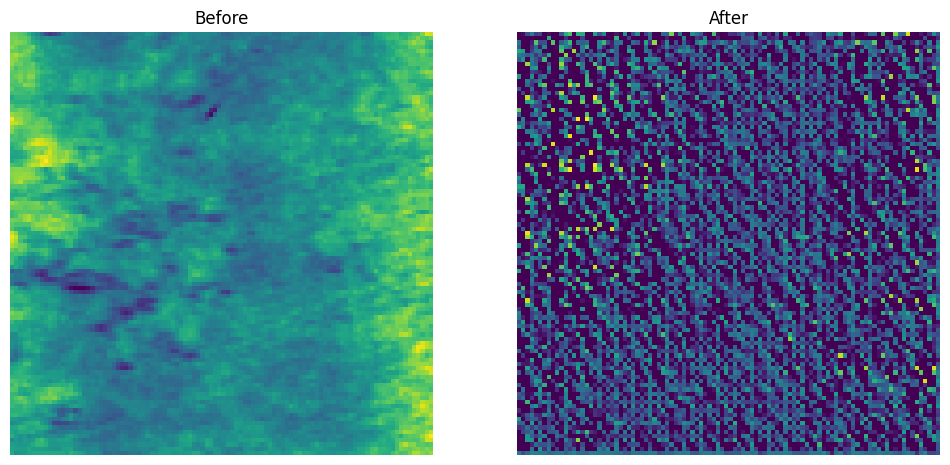

In [8]:
clustered_image = autoencoder(image.to("cuda").unsqueeze(1)).squeeze(1).detach().cpu().numpy()
clustered_image = Perspectiver.rgb_to_grayscale(Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(clustered_image[0])))

Perspectiver.plotComparison(imageBefore=original_image, imageAfter=clustered_image)